In [1]:
# Load data
#Load packages
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch
import seaborn as sns
from pyro.infer import Predictive

import warnings
warnings.filterwarnings("ignore")


# Data sources:
# https://data.mendeley.com/datasets/b5r4yztghx/2
# https://www.kaggle.com/code/muonneutrino/mapping-new-york-city-census-data/data
# https://www.kaggle.com/code/muonneutrino/mapping-new-york-city-census-data/data?select=nyc_census_tracts.csv

# project (Rico)
# https://www.sciencedirect.com/science/article/abs/pii/S1877584518301175
# https://mc-stan.org/users/documentation/case-studies/icar_stan.html


# Artikel
# https://www1.nyc.gov/assets/doh/downloads/pdf/epi/databrief86.pdf

### perfomrnace metrics
Following metrics will be used to evaluate the performance of the models and how good they are at predicting the number of accidents amongst the youth populations.
* Accuracy..
* 

### Data
* Standardised?


#### Feature selection
we have many features, the model can very well be dirven by bias as many features has a high correlation..???

### Models

* baseline model
 >The baseline is based on the assumption that there is a linear relation between the events. The baseline is implemented using a linear regression on the data and will serve as a benchmark when evaluating the performance of the other models.

* Bayesian hierachial model
> From the maps and distributions from the exploratory analysis it seemed as some locations are more prone to accidents. Using an hierachical model it is investigeated if we can naturally cluster data into some groups and thereby be able to predict more accurately. Bayesian Hierachical models are able to produce robust models with clustered data. As the data seemed to cluster dependent on county, this is investigated. 

**copied** https://towardsdatascience.com/introduction-to-hierarchical-modeling-a5c7b2ebb1ca

 this method, parameters are nested within one another at different levels of groups. Roughly, it gives us the weighted average of the unpooled and pooled model estimates. Hierarchical modeling is one of the most powerful, yet simple, techniques in Bayesian inference and possibly in statistical modeling.


* Models with a non linear assumption
    > Extension of the hierachical model to include non linearity



* ???




### Function to performance metrics (?)

In [2]:
def compute_error(trues, predicted):
    """Fucntion to compute errors on ml model

    Args:
        trues (_type_): _description_
        predicted (_type_): _description_

    Returns:
        _type_: _description_
    """
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    mse = np.sum((predicted - trues)**2)/len(trues)
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, mse, r2

In [3]:
# Visualize predictions from the combined model and linear regression
def plot_predictions_comp(y_test,y_pred1,title1,y_pred2, title2):
    """plot to show predictions 

    Args:
        y_test (_type_): true y values
        y_pred1 (_type_): predictions for model
        title1 (_type_): title for first predicitons
        y_pred2 (_type_): predictions for model
        title2 (_type_): title for second prediction
    """
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    ax[0].plot(y_test, label="Targets")
    ax[0].plot(y_pred1, label=title1, alpha=0.85)
    ax[0].legend()
    ax[0].set_xlabel("Observations")

    ax[1].plot(y_test, label="Targets")
    ax[1].plot(y_pred2, label=title2, alpha=0.85)
    ax[1].legend()
    ax[1].set_xlabel("Observations")
    plt.show()
    
    

In [4]:
def plot_scatter(X_test,y_test,y_pred, title):
    plt.plot(X_test[:,0], y_test, "rx")
    plt.plot(X_test[:,0], y_pred, 'bo')
    plt.legend(["true (noisy) data points", title])
    plt.show()

NameError: name 'ypred_lreg' is not defined

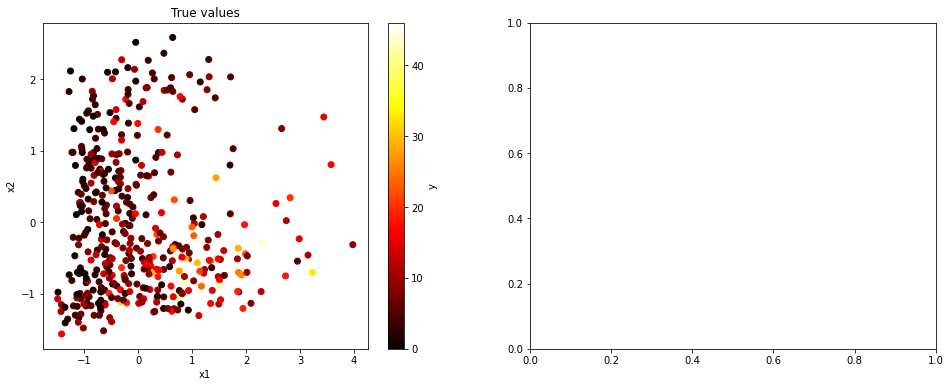

In [17]:
fig = plt.figure(figsize=(16,6))
ax = fig.subplots(1,2)
sc = ax[0].scatter(X_test_std[:,0], X_test_std[:,1], c=y_test, cmap=plt.cm.hot)
ax[0].set_title('True values')
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x2")
plt.colorbar(sc, ax=ax[0], label="y")
sc = ax[1].scatter(X_test_std[:,0], X_test_std[:,1], c=ypred_lreg, cmap=plt.cm.hot)
ax[1].set_title('Predicted values (linear regression)')
ax[1].set_xlabel("x1")
ax[1].set_ylabel("x2")
plt.colorbar(sc, ax=ax[1], label="y")
plt.show()

### Functions
* split function
* data standardisation function
* 

Cosinder moving to another file location (?)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model

In [6]:

 # Get input, output and groups by counties.
 def split_data(df, attributes,impute = False):
    X = df[df.columns[~df.columns.isin(attributes)]] 
    
    # Handling missing data - impute data based on the median.
    if impute:
        X = X.fillna(X.median()).values
    
    # Target variable
    y = df["ped_injury_5to18"].values
    y_mean = y.mean()
    y_std = y.std()

    
    # factorizes counties from strings to numerical valuers
    cat_fact = df['County'].factorize()
    cat = cat_fact[0] # numerical values for counties
    cat_string = cat_fact[1] # string values for counties

    # predictive variable - number of individuals for each census tracts
    ind = df.values[:,1].astype("int")
    
    # split data into train and test using permutation
    train_perc = 0.80 # percentage of training data
    split_point = int(train_perc*len(y))
    perm = np.random.permutation(len(y))
    ix_train = perm[:split_point]
    ix_test = perm[split_point:]
    X_train = X[ix_train,:]
    X_test = X[ix_test,:]
    cat_train = cat[ix_train]
    cat_test = cat[ix_test]
    y_train = y[ix_train]
    y_test = y[ix_test]
    ind_train = ind[ix_train]
    ind_test = ind[ix_test]
    

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, cat_train.shape, cat_test.shape)
    
    return (X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string, (y_mean, y_std)



def standardization(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

### Load and prepare data for modelling

In [7]:
# Load data
df_all = pd.read_csv("data/data_merged.csv")  

In [8]:
# df_all.info()

In [9]:
    # Attriutes that are stirng - either make the dummy variables or remove them
string_att = list(df_all.columns[df_all.dtypes == object])
    # df_all.loc[:, df_all.dtypes == object]
nominal = ['census_tract']
removed_attributes = nominal+string_att
removed_attributes.append("ped_injury_5to18")

# split target variables and variables into training and test data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(y_mean, y_std)  = split_data(df_all, removed_attributes,True)

(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [10]:
feat_names = ['youth_pop_5to18',
       'commute_priv_vehicle', 'med_hhincome', 'avg_ann_daily_traffic',
       'fragment_index', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']

In [11]:
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)

In [12]:
y_train_std = standardization(y_train)
y_test_std = standardization(y_test)

**OBS: TILFØJ! - Burde man kigge på balancen af splittet i forhold til counties evt?**
* imbalanced datasæt

# Baseline model

An Ordinary least square regression is performed

In [20]:
# make linear regression model
l_reg = linear_model.LinearRegression(fit_intercept=False)
l_reg.fit(X_train_std, y_train_std)


LinearRegression(fit_intercept=False)

In [14]:
# Make predictions for test set
ypred_lreg = l_reg.predict(X_test_std)

# Convert back to the original scale
# ypred_lreg = ypred_lreg * y_std + y_mean
# y_true = y_test_std * y_std + y_mean


print("first 5 predictions:", ypred_lreg[:5])
print("first 5 true values:", y_test_std[:5])


# Evaluate prediction accuracy
print("Baseline MSE:", sum((ypred_lreg - y_test_std)**2)/len(ypred_lreg))

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, ypred_lreg)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

# Vi får ikke det samme some de andre - måske noget gal

first 5 predictions: [ 5.74307485 10.59794641 13.33903654  5.26696294  7.75335819]
first 5 true values: [ 3 12 12  4 12]
Baseline MSE: 46.19138075743769
CorrCoef: 0.548
MAE: 4.900
RMSE: 6.796
MSE: 46.191
R2: 0.299


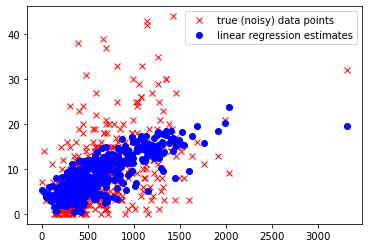

In [15]:
plot_scatter(X_test,y_test,ypred_lreg, "linear regression estimates")

Det ser lidt mærkeligt ud...


### Feature selection

The significance of all variables are now investigated to see if a feature selection would be appropriate.

In [16]:
import statsmodels.api as sm
# Fit Ordinary Least Squares (OLS) model to the data.
X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     23.35
Date:                Thu, 19 May 2022   Prob (F-statistic):          1.46e-123
Time:                        12:04:08   Log-Likelihood:                -5347.0
No. Observations:                1676   AIC:                         1.077e+04
Df Residuals:                    1638   BIC:                         1.098e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -273.6562    434.952     -0.629      0.5

From the OLS Regression Results we can see that many of the variables are statistically insignificant. 
<br> We will thus use Least Angle Regression to select the 8 most significant features.

In [17]:
lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
feature_ids = lars.coef_ != 0
feature_ids = np.array([i for i, incl in enumerate(feature_ids) if incl])
feature_ids_shifted = [0, *(feature_ids + 1)]
print("Features to be included:")
print("-"*20)
for idx in feature_ids:
    print(feat_names[idx])

Features to be included:
--------------------
youth_pop_5to18
commute_priv_vehicle
med_hhincome
White
Black
Poverty
Service
Transit


In [18]:
# Fit new model with 8 most significant features
X2 = sm.add_constant(X_train[:, feature_ids])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     101.4
Date:                Thu, 19 May 2022   Prob (F-statistic):          1.06e-137
Time:                        12:04:40   Log-Likelihood:                -5369.8
No. Observations:                1676   AIC:                         1.076e+04
Df Residuals:                    1667   BIC:                         1.081e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2731      1.941      2.716      0.0

#### Create logistisk regression with the selected features to evaluate performance

In [19]:
# Create and fit regression model only using chosen features
lreg = linear_model.LinearRegression()
X_train = X_train_std
X_test = X_test_std 
lreg.fit(X_train[:, feature_ids], y_train)

# Make predictions for test set
y_pred_lreg_fs = lreg.predict(X_test[:, feature_ids])
print("First 5 predictions:", y_pred_lreg_fs[:5])
print("First 5 true values:", y_test[:5])

# Evaluate prediction accuracy
corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_pred_lreg_fs)
print("\nPerformance metrics\nCorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

First 5 predictions: [ 5.48617143 10.35005898 12.90967786  5.24690938  6.70003111]
First 5 true values: [ 3 12 12  4 12]

Performance metrics
CorrCoef: 0.555
MAE: 4.847
RMSE: 6.814
MSE: 46.431
R2: 0.295


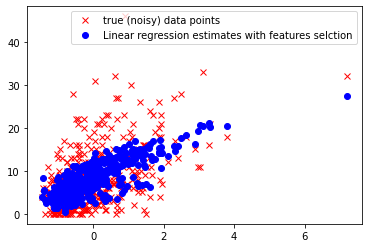

In [33]:
plot_scatter(X_test, y_test,y_pred_lreg_fs, "Linear regression estimates with features selction")

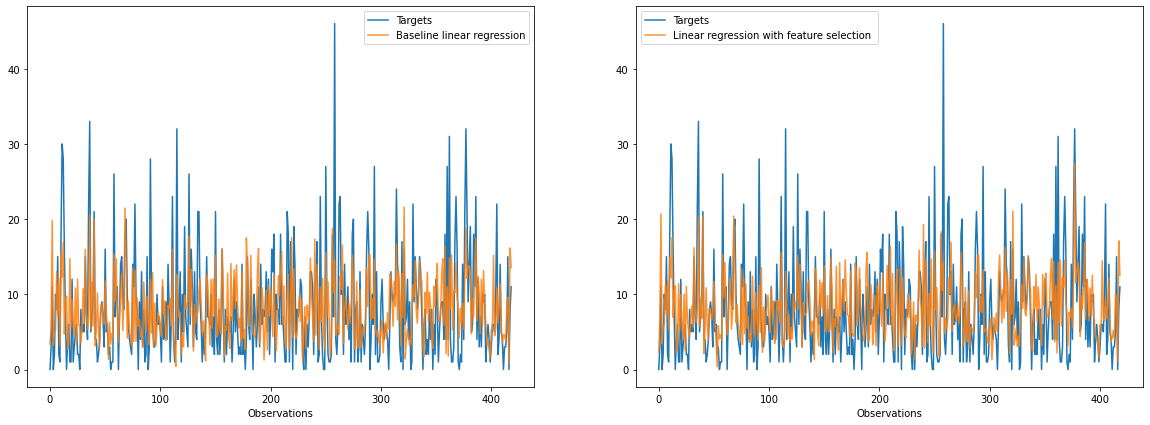

In [34]:
plot_predictions_comp(y_test,ypred_lreg,"Baseline linear regression", y_pred_lreg_fs,"Linear regression with feature selection ")

# Hierachical model

... classification ...

Data is investigated further using a hierachical model, to examine if data are distirbuted dependent on some underlying patterns that can help us in our prediction model. 

The hierachical model is based upon the assumption that some areas are more prone to accidents that other accidents. This assumption is made based on the exploratory analysis where it was evident that XXX and XX were two areas that had more accidents compared to the others. 

In the hierarchical model data are grouped into L distinct levels. The model is buildt such that on one extreme each level is assigned its own set of parameters that is estimated seperately from the other levels resulting in no pooling, and the other extreme where all data share a common globar hyper prior that ties the parameters of each level together resulring in complete pooling. In this wat the hierarchical model is an intermediate solution where the degree of pooling is determined by the data and a prior on the amount of pooling \ref{https://mc-stan.org/docs/2_23/stan-users-guide/hierarchical-logistic-regression.html}



the prediction variable is the categorial variable cat, as we are prediction counties 



Priors
* Dispersion variable: We do not know the time distirbution of when the accidents occur we will add a dispersion variable (q_gamma). In this way we have a prior for the distirbution of time...
        > alpha, beta. alpha is the total number of occurences in beta intervals (latent) variable
        > posterior predictive --> use the negative binomial
        > lecture 3_ https://learn.inside.dtu.dk/d2l/le/content/102751/viewContent/410012/View







In [21]:
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [22]:
# split data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(y_mean, y_std)  = split_data(df_all, removed_attributes,True)
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)

(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


### Hierarchical model with logistic regression

In [23]:

def hierarchical_model_lr(X ,ind, n_cat, n_ind, obs=None):
    """_Hierarchical logistic regression_
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Draw parameters 
    
    # Prior for the bias mean
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(torch.zeros(n_cat), 
                                                       10.*torch.ones(n_cat)).to_event()) 
    # Prior for the bias standard deviation
    alpha_sigma  = pyro.sample("alpha_sigma",  
                               dist.HalfCauchy(10.*torch.ones(n_cat)).to_event()) 
    
    
    # Priors for the regression coefficents
    beta  = pyro.sample("beta", 
                        dist.Normal(
                            torch.zeros(input_dim, n_cat), 
                                            10.*torch.ones(input_dim, n_cat)).to_event())
        
    
    # Group level
    with pyro.plate("level", n_ind):
        # Draw linear coefficient parameters for each level (no pooling)
        alpha = pyro.sample(
            "alpha",
                dist.Normal(alpha_mu, alpha_sigma).to_event(1)
        )
        
    # per individual
    with pyro.plate("observations", N):
        
        # regression model
        logits = alpha[ind] + X.matmul(beta)

        # Sample prediction using logits (then we do not need softmax)
        y = pyro.sample("y", 
                        dist.Categorical(logits=logits), 
                        obs=obs) 
        
        
        
    
    return y

Next step is to prepare data for pyro in order to use the model to predict

In [24]:

# Prepare data for Pyro model
# convert ty torch tensors
X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
cat_train = torch.tensor(cat_train).long()
y_train = torch.tensor(y_train).long()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
n_ind = ind.max()

# number of coutnies
n_cat = int(len(df_all['County'].unique()))
#n_cat_amx = ind.max()

#ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

In [25]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model_lr)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_model_lr, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, y_train-1, n_cat, n_ind, cat_train)
    # hierarchical_model_lr(X ,ind, n_cat, n_ind, obs=None)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 17937.6
[500] ELBO: 6482.7
[1000] ELBO: 3018.5
[1500] ELBO: 2172.9
[2000] ELBO: 1835.4
[2500] ELBO: 1679.7
[3000] ELBO: 1620.1
[3500] ELBO: 1580.0
[4000] ELBO: 1541.2
[4500] ELBO: 1520.7
[5000] ELBO: 1511.5
[5500] ELBO: 1515.0
[6000] ELBO: 1511.7
[6500] ELBO: 1501.5
[7000] ELBO: 1506.6
[7500] ELBO: 1508.2
[8000] ELBO: 1504.9
[8500] ELBO: 1503.9
[9000] ELBO: 1496.0
[9500] ELBO: 1500.1
[10000] ELBO: 1495.7
[10500] ELBO: 1493.6
[11000] ELBO: 1508.8
[11500] ELBO: 1496.8
Wall time: 5min 8s


Extract the posterior samples and investigate if any county is more likely to have accidents than others

In [26]:
# Extract the posterior samples
predictive = Predictive(hierarchical_model_lr, guide=guide, num_samples=2000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train_std_fs, y_train-1, n_cat, n_ind, cat_train-1)


# plot the posterior distirbution of the parameters
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

NameError: name 'fig' is not defined

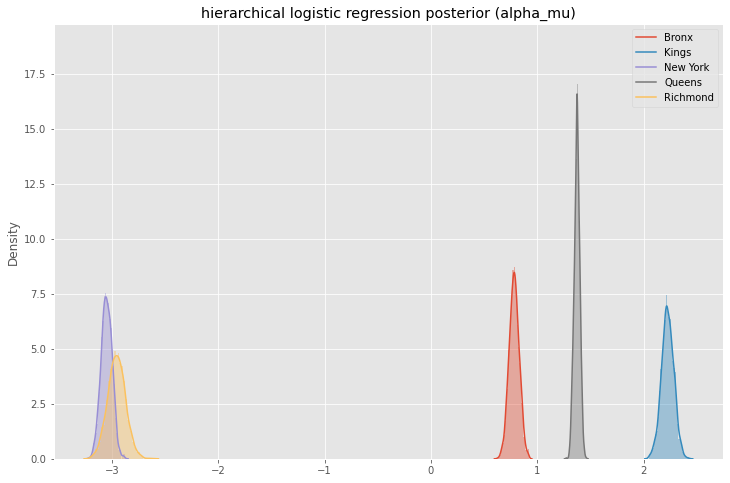

In [27]:
def plot_county_dist(posterior, save_csv, no_cat = n_cat, legend_names = cat_string):
    for c in range(no_cat):
        sns.distplot(posterior[:,0,c])
    plt.legend([legend_names[c] for c in range(no_cat)])
    plt.title(save_csv)
    fig.savefig('output/'+save_csv+'.pdf', format="pdf")
    plt.show()
    
plot_county_dist(alpha_mu_samples, 'hierarchical logistic regression posterior (alpha_mu)', no_cat = n_cat, legend_names = cat_string)


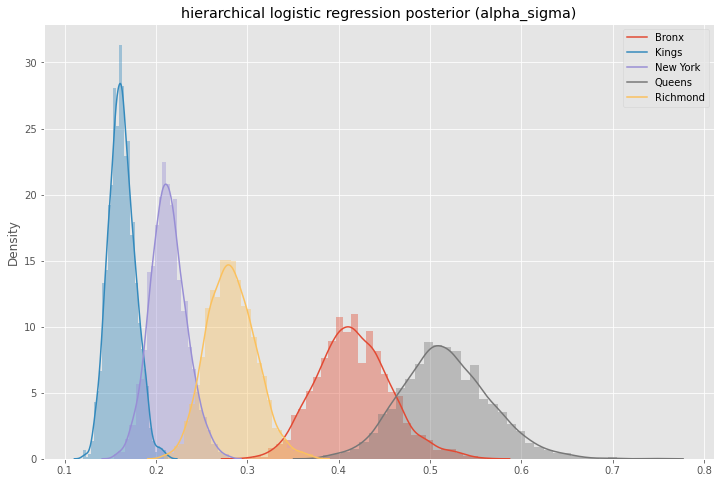

In [90]:
plot_county_dist(alpha_sigma_samples, 'hierarchical logistic regression posterior (alpha_sigma)', no_cat = n_cat, legend_names = cat_string)

Te model has not seperated the parameters that much?

**make predictions**
We can now use the inferred poseriors to make predictions. irst the expetec values for the paraemters, it is possible to make prediction for the test set.

In [92]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"][:,0].mean(axis=0).detach().numpy()


# make predictions for test set using the linear assumption and the logistic regression
# Returns the county that has the highest value
y_hat1 = alpha_hat[y_test-1] + np.dot(X_test_std_fs, beta_hat)
y_hat = np.argmax(y_hat1, axis=1) 

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == cat_test) / len(cat_test))

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))


Accuracy: 0.38424821002386633
CorrCoef: -0.591
MAE: 7.475
RMSE: 10.512
MSE: 110.511
R2: 0.000


In [93]:
dictionary = {
     0 :"Bronx",
    1 : "Kings",
    2 :"New York",
    3 : "Queens",
    4 : "Richmond",
}


df = pd.DataFrame(y_hat, columns = ['y_hat'])

df['county'] = df['y_hat'].apply(lambda x : dictionary[x])



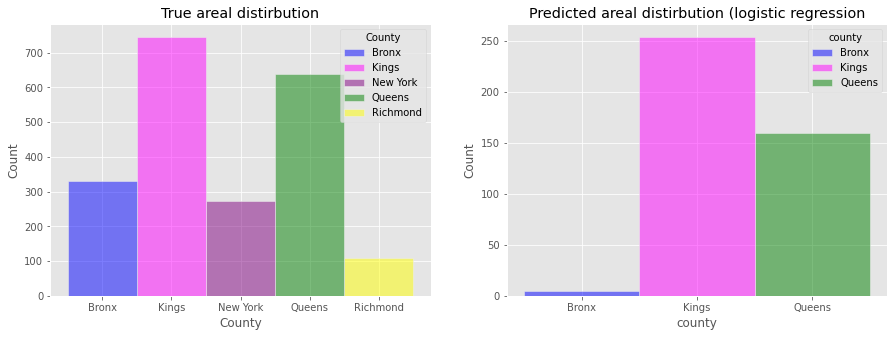

In [94]:
df_all = df_all.sort_values(by=['County'])
df = df.sort_values(by=['county'])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

sns.histplot(data=df_all, x="County", hue="County", ax=axs[0], palette=palette)
sns.histplot(data=df, x="county", hue="county", ax=axs[1], palette=palette)
axs[0].title.set_text('True areal distirbution')
axs[1].title.set_text('Predicted areal distirbution (logistic regression')
plt.show()

### Hierarchical model with probaility distirbution?? -gamma
# <span style="color:red">HER
</span>

In [30]:
# split data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(y_mean, y_std)  = split_data(df_all, removed_attributes,True)
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)

(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [66]:
def hierarchical_model(X ,cat, n_cat, obs=None):
    """_Hierarchical with gamma distribution as conjungate prior distribution to poisson with hyper parameters alpha and beta. 
        Using negative binomial as posterior predictive_
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Draw parameters 
    alpha_gamma = 2
    beta_gamma = 4
    
    sigma_beta = 1
    mu_beta = 0
    
    # Draw priors
    # gamma distirbution
    
    
    q = pyro.sample("q", dist.Gamma(alpha_gamma, beta_gamma))
    q = torch.exp(q)
    #sigma_psi = pyro.sample("sigma", dist.HalfCauchy(1))
    
    
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        
        alpha = pyro.sample(
            "alpha",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
        # Draw linear coefficient parameters for each level (no pooling)
        beta = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        sigma = pyro.sample(
            "sigma",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        # create link function  
        # compute mean for psi distirbution using a linear model
        #sigma_psi =  dist.Normal(torch.zeros(N),torch.ones(N))
        
        
        
        psi_mu = torch.sum(alpha[cat] + X *beta[cat] +sigma[cat], axis = 1) 
        p_i = torch.exp(psi_mu)/(1+torch.exp(psi_mu))
        
        #psi = pyro.sample("psi", dist.Normal(psi_mu, sigma_psi))
        
        #y = pyro.sample("y", dist.Poisson(torch.exp(alpha + psi_mu)), obs=obs)
        # Sample prediction using negative binomial on gamma prior as posterior predictive disitrbution (wiki)
        y = pyro.sample("y", 
                        dist.NegativeBinomial(q,probs=p_i), 
                        obs=obs) 
        
    
    return y

In [67]:
#feature_ids_shifted = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
#X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
#X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  


In [68]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# hierarchical_model(X ,cat, n_cat, n_ind, ind, obs=None)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, cat_train, n_cat, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 7786.5
[500] ELBO: 5333.1
[1000] ELBO: 5261.3
[1500] ELBO: 5376.9
[2000] ELBO: 5302.0
[2500] ELBO: 5253.4
[3000] ELBO: 5279.9
[3500] ELBO: 5283.4
[4000] ELBO: 5293.0
[4500] ELBO: 5276.5
[5000] ELBO: 5276.5
[5500] ELBO: 5300.5
[6000] ELBO: 5303.7
[6500] ELBO: 5351.9
[7000] ELBO: 5284.3
[7500] ELBO: 5257.9
[8000] ELBO: 5271.6
[8500] ELBO: 5271.1
[9000] ELBO: 5317.6
[9500] ELBO: 5266.9
Wall time: 4min 33s


Extract the posterior samples for the latent vairables using the puro class

In [69]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=4000,
                        return_sites=("beta", "q", "y", "sigma_cauchy","alpha"))
samples = predictive(X_train_std_fs[:,:], cat_train, n_cat, y_train)



In [70]:
# plot the posterior distirbution of the parameters
beta_samples = samples["beta"].detach().numpy()
gamma_q_samples = samples["q"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()


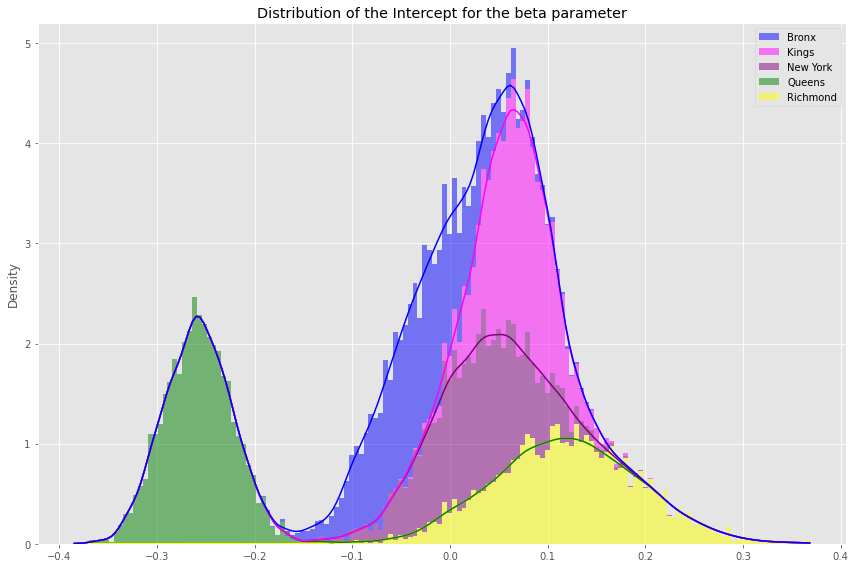

In [71]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

# create dataframe and set columns for the relevant counties
df = pd.DataFrame(alpha_samples[:,:,0])
df.columns = [cat_string[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette)
plt.title(f"Distribution of the Intercept for the beta parameter")
fig.tight_layout()
#fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
plt.show()

### Predictions with the hierarchical model
Using the expected values of beta and q from the posterior samples

In [74]:
# Predict by computing the mean of parameters and passing through NB dist
beta_hat = np.mean(beta_samples, axis=0)
q_hat = np.mean(gamma_q_samples, axis=0)
alpha_hat = np.mean(alpha_samples, axis=0)

psi = np.sum(alpha_hat[cat_test]+ beta_hat[cat_test] * X_test_std_fs[:, :].numpy(), axis=1)
NB_d = dist.NegativeBinomial(torch.tensor(q_hat), logits=torch.tensor(psi))
y_hat_mean = np.array(NB_d.mean) # Extract mean from NB dist and use as prediction

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat_mean)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))


CorrCoef: 0.429
MAE: 6.192
RMSE: 9.408
MSE: 88.518
R2: 0.000


In [76]:
# Predict by computing the median
beta_med = np.median(beta_samples, axis=0)
q_med = np.median(gamma_q_samples, axis=0)
psi = np.sum(beta_med[cat_test] * X_test_std_fs[:, :].numpy(), axis=1)
NB_d = dist.NegativeBinomial(torch.tensor(q_med), logits=torch.tensor(psi))
y_hat = np.array(NB_d.mean)
corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))



CorrCoef: 0.496
MAE: 7.124
RMSE: 10.286
MSE: 105.803
R2: 0.000


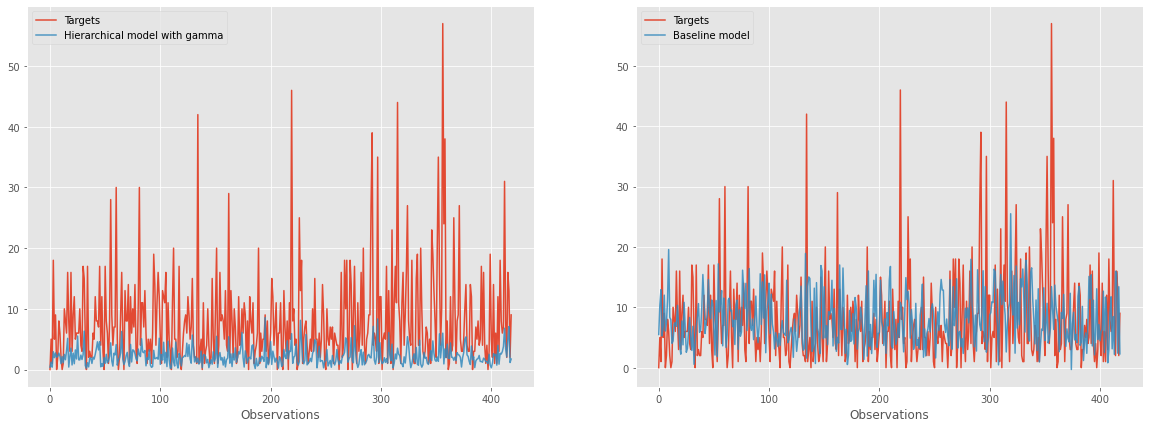

In [78]:
plot_predictions_comp(y_test,y_hat_mean,"Hierarchical model with gamma",y_pred_lreg_fs,"Baseline model")

## Hierarchical modelling with poisson distribution


In [51]:
# split data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(y_mean, y_std)  = split_data(df_all, removed_attributes,True)
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)



(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [52]:
def hierarchical_model_pois(X ,cat, n_cat, obs=None):
    """_Hierarchical with poisson distribution
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Draw parameters 
    
    sigma_beta = 1
    mu_beta = 0
    
    # Draw priors

    #alpha = pyro.sample("alpha", dist.Normal(0., 1.))    
    
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        # Draw linear coefficient parameters for each level (no pooling)
        alpha = pyro.sample(
            "alpha",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
        
        beta = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        
    # per individual 
    with pyro.plate("observations", N):
        
        # create link function  
        
        psi_mu = torch.sum(alpha[cat] + X *beta[cat], axis = 1) 
        
    
        y = pyro.sample("y", dist.Poisson(torch.exp(psi_mu)), obs=obs)
        

        
        # Sample prediction using negative binomial on gamma prior as posterior predictive disitrbution (wiki)
  
    
    return y


In [53]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
# X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
# X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  




In [54]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model_pois)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model_pois, guide, optimizer, loss=elbo)

# hierarchical_model(X ,cat, n_cat, n_ind, ind, obs=None)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, cat_train, n_cat, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 29176.1
[500] ELBO: 6496.8
[1000] ELBO: 6399.7
[1500] ELBO: 6391.3
[2000] ELBO: 6386.2
[2500] ELBO: 6379.8
[3000] ELBO: 6387.9
[3500] ELBO: 6383.3
[4000] ELBO: 6386.1
[4500] ELBO: 6383.1
[5000] ELBO: 6385.9
[5500] ELBO: 6384.4
[6000] ELBO: 6382.3
[6500] ELBO: 6386.5
[7000] ELBO: 6383.5
[7500] ELBO: 6386.1
[8000] ELBO: 6385.2
[8500] ELBO: 6383.8
[9000] ELBO: 6382.4
[9500] ELBO: 6390.6
Wall time: 1min 22s


Extract the posterior samples for the latent vairables using the puro class

In [56]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model_pois, guide=guide, num_samples=4000,
                        return_sites=("beta", "q", "y", "sigma_cauchy", "alpha"))
samples = predictive(X_train_std_fs[:,:], cat_train, n_cat, y_train)



In [57]:
# plot the posterior distirbution of the parameters
beta_samples_hp = samples["beta"].detach().numpy()
alpha_samples_hp = samples["alpha"].detach().numpy()
#gamma_q_samples = samples["q"].detach().numpy()


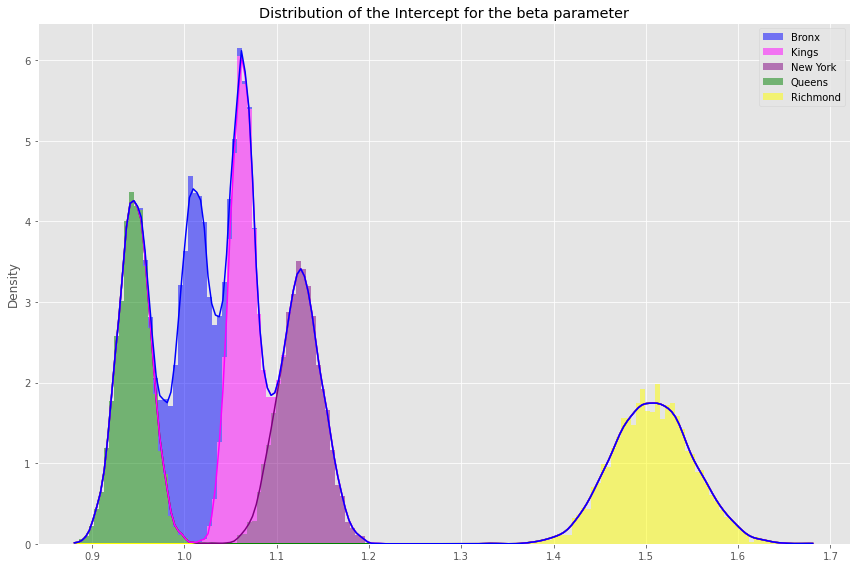

In [58]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

# create dataframe and set columns for the relevant counties
df = pd.DataFrame(alpha_samples_hp[:,:,0])
df.columns = [cat_string[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette)
plt.title(f"Distribution of the Intercept for the beta parameter")
fig.tight_layout()
#fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
plt.show()

### Predictions with the hierarchical model
Using the expected values of beta and q from the posterior samples

In [59]:
beta_hat = np.mean(beta_samples, axis=0)

     #psi_mu = torch.sum(X *beta[cat], axis = 1) 
        
    
        #y = pyro.sample("y", dist.Poisson(torch.exp(alpha + psi_mu)), obs=obs)

psi = np.sum(beta_hat[cat_test] * X_test_std_fs[:, :].numpy(), axis=1)


alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()

y_hat_hpois = np.mean(np.exp(alpha_samples[:,0].T.sum(axis=0) + np.dot(X_test_std_fs, beta_samples[:,0].T)), axis=1)

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat_hpois)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))



CorrCoef: 0.498
MAE: 4.518
RMSE: 6.309
MSE: 39.807
R2: 0.224


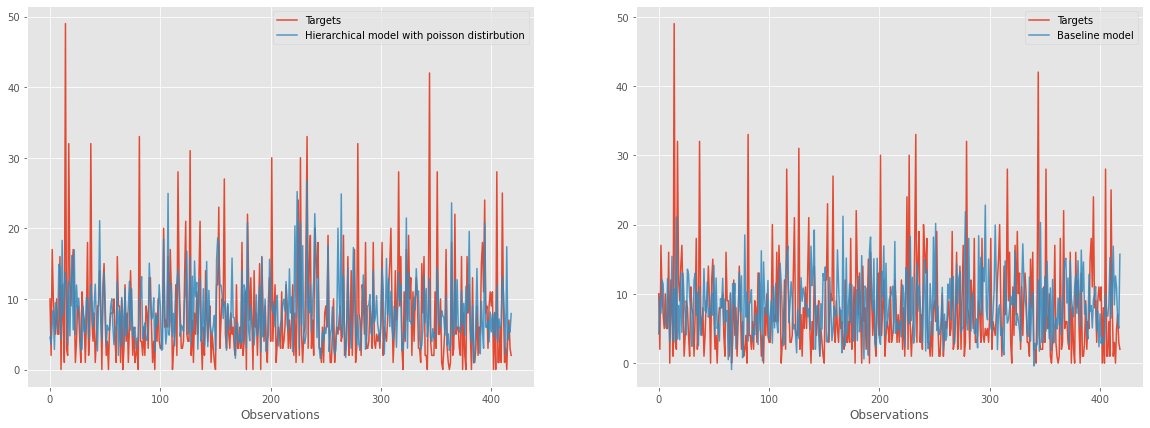

In [60]:
plot_predictions_comp(y_test,y_hat_hpois,"Hierarchical model with poisson distirbution",y_pred_lreg_fs,"Baseline model")

## Regression model - Bayesian poisson distirbution

Based on the expoloratory analysis it could be interesting to see how a poisson regression model is on our data. It can be seen that the target variable does not follow a normal distribution

In [61]:
# split data
(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(y_mean, y_std)  = split_data(df_all, removed_attributes,True)
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)

(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [62]:
def poisson_model(X, obs=None):
    """Bayesian poisson model 

    Args:
        X (_type_): X train
        obs : y train

    Returns:
        _type_: predicitons
    """
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
    return y

In [65]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  



In [66]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 20408.6
[500] ELBO: 7381.3
[1000] ELBO: 7148.4
[1500] ELBO: 6504.5
[2000] ELBO: 6448.5
[2500] ELBO: 6466.7
[3000] ELBO: 6398.6
[3500] ELBO: 6412.0
[4000] ELBO: 6388.7
[4500] ELBO: 6396.1
[5000] ELBO: 6395.8
[5500] ELBO: 6396.6
[6000] ELBO: 6398.3
[6500] ELBO: 6389.5
[7000] ELBO: 6388.9
[7500] ELBO: 6389.5
[8000] ELBO: 6390.0
[8500] ELBO: 6392.4
[9000] ELBO: 6388.4
[9500] ELBO: 6388.8


In [67]:
from pyro.infer import Predictive

predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_std_fs, y_train)

In [68]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test_std_fs, beta_samples[:,0].T)), axis=1)

# convert back to the original scale
y_preds_poisson = y_hat # no need to do any conversion here because the Poisson model received untransformed y's
y_true = y_test

corr, mae, rae, rmse, mse, r2 = compute_error(y_true, y_preds_poisson)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))

CorrCoef: 0.543
MAE: 4.480
RMSE: 6.562
MSE: 43.065
R2: 0.294


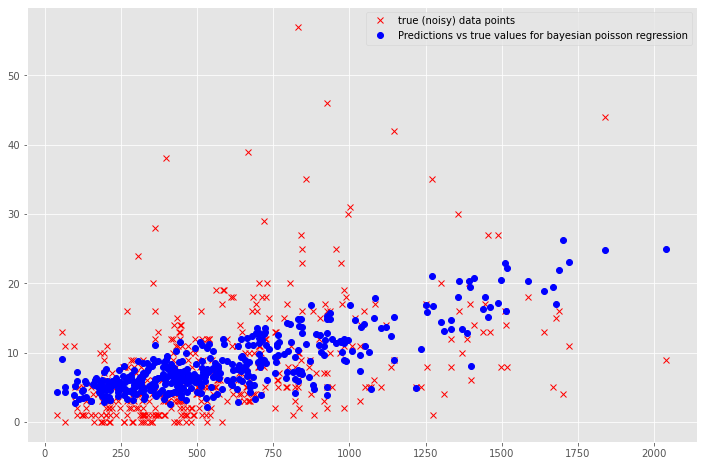

In [69]:
plot_scatter(X_test,y_test,y_preds_poisson, "Predictions vs true values for bayesian poisson regression")

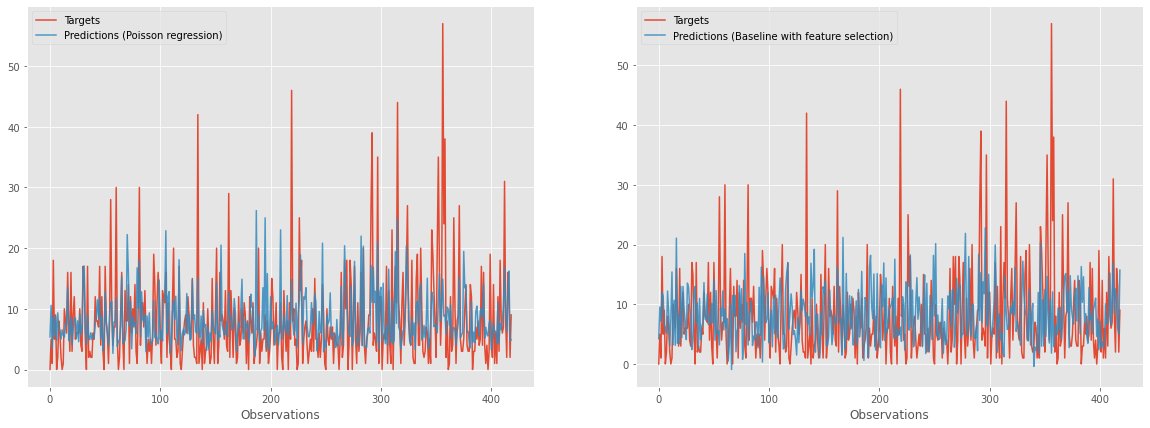

In [70]:
# Visualize predictions from the hierarchical model and linear regression
plot_predictions_comp(y_test,y_preds_poisson,"Predictions (Poisson regression)",y_pred_lreg_fs, "Predictions (Baseline with feature selection)")


## Regression model - Bayesian neural network - poisson 

Model linear and non linear dependecies






$$
f_{nnet}(X_n)+\phi_n
$$

In [71]:
# Prepare data for Pyro model

(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(_,_) = split_data(df_all, removed_attributes,True)

# standardise data - evt slette?
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)


(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [55]:
# Create architecture
from torch import nn, Tensor
import torch.optim as optim
from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam

class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden1)
        self.h1_layer = torch.nn.Linear(n_hidden1, n_hidden2)
        self.h2_layer = torch.nn.Linear(n_hidden2, n_hidden2)
        self.out_layer = torch.nn.Linear(n_hidden2, n_out)
        
        # Activation functions
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        # Forward pass
        X = self.relu(self.in_layer(X))
        X = self.relu(self.h1_layer(X))
        X = self.relu(self.h2_layer(X))
        X = self.out_layer(X)
        
        return X

Adding priors in the neural network on its weights

In [73]:

def nnet_interpretable_model(X, y=None):
    
    # Number of observations and features
    N, input_dim = X.shape
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1]-1, n_hidden1=7,n_hidden2=3, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(0, 1))                    # Prior for the coefficients
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    
    
    # The generative process
    with pyro.plate("observations"):
        linear_out = X[:,0]*beta_lin
        
        nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
        
        #phi = torch.exp(linear_out+nn_out)
        #phi = exp(linear_out)
        
        #q = exp(nn_out)
        
        ##y = pyro.sample("obs", dist.Normal(linear_out+nn_out, 0.1), obs=y)
        
        
        y = pyro.sample("obs", dist.Poisson(torch.exp(linear_out + nn_out)), obs=y)
        
        #y = pyro.sample("obs", dist.poisson(phi, 0.1), obs=y)
   
        
        
    return y

    

In [75]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train = torch.tensor(X_train[:,feature_ids]).float()
X_test = torch.tensor(X_test[:,feature_ids]).float()

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  


In [77]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 27745.3
[500] ELBO: 6684.0
[1000] ELBO: 6294.8
[1500] ELBO: 6254.0
[2000] ELBO: 6234.2
[2500] ELBO: 6143.7
[3000] ELBO: 6138.4
[3500] ELBO: 6192.1
[4000] ELBO: 6121.2
[4500] ELBO: 6147.1
[5000] ELBO: 6095.3
[5500] ELBO: 6153.4
[6000] ELBO: 6144.4
[6500] ELBO: 6253.9
[7000] ELBO: 6160.3
[7500] ELBO: 6134.0
[8000] ELBO: 6236.1
[8500] ELBO: 6132.3
[9000] ELBO: 6100.5
[9500] ELBO: 6176.0


In [78]:
# Get posterior samples for beta
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("beta",))
samples = predictive(X_train_std_fs, y_train)

In [79]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Estimated beta: 0.6463378


In [81]:
# Make predictions for test set
predictive = Predictive(nnet_interpretable_model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test_std_fs)

y_pred_neural = samples["obs"].mean(axis=0).detach().numpy()
mae = np.mean(np.abs(y_test - y_pred_neural))
print("MAE:", mae)


corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_pred_neural)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))


MAE: 4.578615733717962
CorrCoef: 0.472
MAE: 4.579
RMSE: 6.927
MSE: 47.989
R2: 0.188


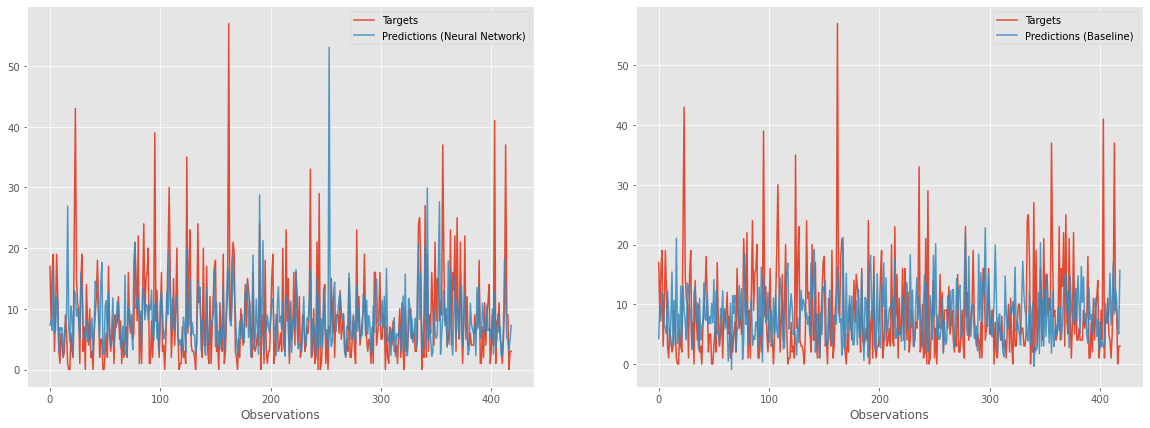

In [82]:
plot_predictions_comp(y_test,y_pred_neural,"Predictions (Neural Network)",y_pred_lreg_fs, "Predictions (Baseline)")

## Neural network on q
# <span style="color:red">HER
</span>

In [112]:
#load data

# Prepare data for Pyro model

(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(_,_) = split_data(df_all, removed_attributes,True)

# standardise data - evt slette?
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)


(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [113]:

def nnet_interpretable_model_gamma(X, y=None):
    
    # Number of observations and features
    N, input_dim = X.shape
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1]-1, n_hidden1=7,n_hidden2=3, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    
    # parameters
    alpha_gamma = 2
    beta_gamma = 4 
    
    # Linear model priors
    beta_lin = pyro.sample("beta", dist.Normal(0, 1))                    # Prior for the coefficients
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    
    q = pyro.sample("q", dist.Gamma(alpha_gamma, beta_gamma))               
    q = torch.exp(q)
    
    # The generative process
    with pyro.plate("observations"):
        linear_out = X[:,0]*beta_lin
        nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
        psi_mu = (linear_out +nn_out) 
        p_i = torch.exp(psi_mu)/(1+torch.exp(psi_mu))
        
        y = pyro.sample("obs", dist.NegativeBinomial(q,probs=p_i), obs=y)
            
    return y

    

In [114]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train = torch.tensor(X_train[:,feature_ids]).float()
X_test = torch.tensor(X_test[:,feature_ids]).float()

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  


In [115]:
# Define guide function
guide = AutoDiagonalNormal(nnet_interpretable_model_gamma)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(nnet_interpretable_model_gamma, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 5804.2
[500] ELBO: 5033.1
[1000] ELBO: 5022.9
[1500] ELBO: 5021.7
[2000] ELBO: 5040.3
[2500] ELBO: 4992.3
[3000] ELBO: 5023.0
[3500] ELBO: 4993.5
[4000] ELBO: 5010.5
[4500] ELBO: 5010.7
[5000] ELBO: 4994.5
[5500] ELBO: 5069.2
[6000] ELBO: 4992.0
[6500] ELBO: 4993.1
[7000] ELBO: 5038.7
[7500] ELBO: 5005.5
[8000] ELBO: 5011.2
[8500] ELBO: 5018.4
[9000] ELBO: 5021.5
[9500] ELBO: 5066.9


In [122]:
# Get posterior samples for beta
predictive = Predictive(nnet_interpretable_model_gamma, guide=guide, num_samples=1000,
                        return_sites=("q","beta",))
samples = predictive(X_train_std_fs, y_train)

In [123]:
print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy()[0])

Estimated beta: 0.86034113


In [128]:
# Make predictions for test set
predictive = Predictive(nnet_interpretable_model_gamma, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test_std_fs)

y_pred_neural_gamma = samples["obs"].mean(axis=0).detach().numpy()
#mae = np.mean(np.abs(y_test - y_pred_neural))
#print("MAE:", mae)


corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_pred_neural_gamma)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))


CorrCoef: 0.554
MAE: 4.703
RMSE: 6.606
MSE: 43.642
R2: 0.297


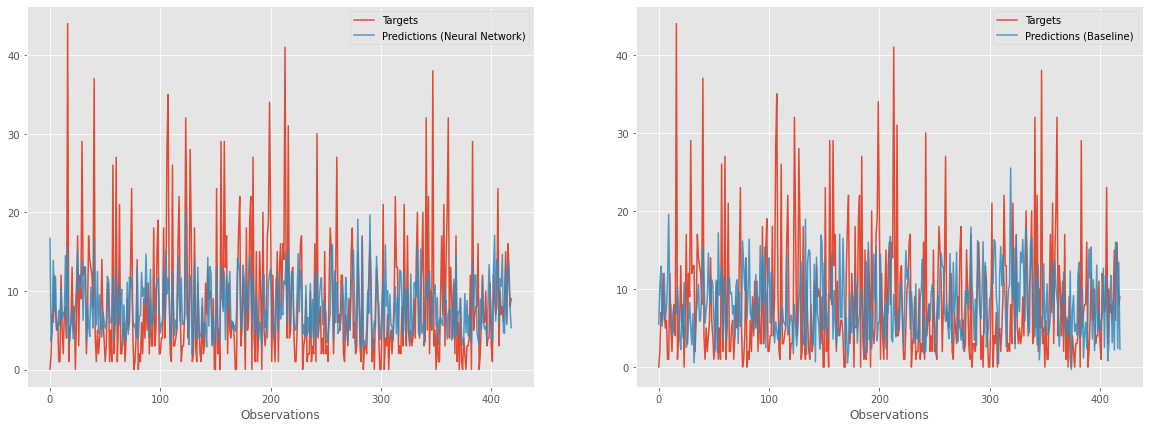

In [129]:
plot_predictions_comp(y_test,y_pred_neural_gamma,"Predictions (Neural Network)",y_pred_lreg_fs, "Predictions (Baseline)")

# <span style="color:red">Hierachical poisson model with a non linear assumption neural net
</span>

In [263]:
#load data

# Prepare data for Pyro model

(X_train, X_test), (y_train, y_test), (cat_train,cat_test), (ind_train,ind_test), ind, cat_string,(_,_) = split_data(df_all, removed_attributes,True)

# standardise data - evt slette?
X_train_std = standardization(X_train)
X_test_std = standardization(X_test)


(1676, 38) (419, 38) (1676,) (419,) (1676,) (419,)


In [267]:
def hierarchical_model_nn_pois(X ,cat, n_cat, obs=None):
    """_Hierarchical with poisson distribution
    
    

    Args:
        X (matrix): data observations (prediciton vairables)
        n_cat (int): number of categories (different counties)
        obs (_type_, optional): _description_. Defaults to None.
        y (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    
    
    # Number of observations and features
    N, input_dim = X.shape
    
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1]-1, n_hidden1=7,n_hidden2=3, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    
    for name, par in torch_model.named_parameters():     # Loop over all neural network parameters
        priors[name] = dist.Normal(torch.zeros(*par.shape), 
                                   torch.ones(*par.shape)).to_event() # Each parameter has a N(0, 1) prior
    
    
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) # Make this model and these priors a Pyro model
    sampled_model = bayesian_model()                                           # Initialize the model
    
    
    
    # Linear model priors
    #beta_lin = pyro.sample("beta", dist.Normal(0, 1))                    # Prior for the coefficients
    #alpha = pyro.sample("alpha", dist.Normal(0., 1.))                    # Prior for the bias/intercept
    
    
    # Draw parameters 
    
    sigma_beta = 1
    mu_beta = 0
    
    # Draw priors

    
    # Draw coefficient for the hyper prior beta that tiest the parameters together for the individuals in each group level
    with pyro.plate("level", n_cat):
        # Draw linear coefficient parameters for each level (no pooling)
        beta_lin = pyro.sample(
            "beta",
                dist.Normal(mu_beta*torch.zeros(input_dim), 
                                            sigma_beta*torch.ones(input_dim)).to_event()) 
        alpha = pyro.sample(
            "alpha",
                dist.Normal(0*torch.zeros(input_dim), 
                                            1*torch.ones(input_dim)).to_event()) 
        
        
    # per individual 
    with pyro.plate("observations", N):
        
        #print(torch.sum(beta_lin[cat], axis=0 ))
        #print(X[:,1:].shape)
        #print(X[:,1:].squeeze(-1).shape)
        
        linear_out = X[:,0]*torch.sum(beta_lin[cat],axis=1)
        nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
        #print(linear_out.shape)
        #print(nn_out.shape)
        
        #print((linear_out+nn_out).shape)
        
        
        #linear_out = X[:,0]*beta_lin
        #nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network
        
        #psi_mu = torch.sum(alpha[cat] + X *beta[cat], axis = 1) 
        #y = pyro.sample("y", dist.Poisson(torch.exp(psi_mu)), obs=obs)

        
        # create link function
        #linear_out = torch.sum(X*beta_lin[cat], axis=1) # intercept
        #nn_out = sampled_model(X[:,1:]).squeeze(-1) # Feed-forward the design matrix X through the neural network , remainng columns
        
        
        #psi_mu = torch.sum(X *beta[cat], axis = 1) 
        
        #print(nn_out.shape)
        #print(linear_out.shape)
        
    
        y = pyro.sample("y", dist.Poisson(torch.exp(nn_out + linear_out)), obs=obs)
        
        # Sample prediction using negative binomial on gamma prior as posterior predictive disitrbution (wiki)
  
    
    return y


In [268]:
#feature_ids = [0, *(feature_ids + 1)]
# prepare data for modelling  = > conver tto tensors
n_cat = int(len(df_all['County'].unique())) # maximum number of conties
n_ind = ind.max() # maximal no of injuries pr census tracts

X_train_std_fs = torch.tensor(X_train_std[:,feature_ids]).float()
X_test_std_fs = torch.tensor(X_test_std[:,feature_ids]).float()
y_train = torch.tensor(y_train).float()
cat_train = torch.tensor(cat_train).long()  # these are indices, therefore they need to be (long) integers

# mangler at add intercept
X_train_std_fs = torch.cat((torch.ones(X_train_std_fs.shape[0], 1), X_train_std_fs), dim=-1)
X_test_std_fs = torch.cat((torch.ones(X_test_std_fs.shape[0], 1), X_test_std_fs), dim=-1)  




In [269]:
%%time

# Define guide function
guide = AutoDiagonalNormal(hierarchical_model_nn_pois)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=2)
svi = SVI(hierarchical_model_nn_pois, guide, optimizer, loss=elbo)

# hierarchical_model(X ,cat, n_cat, n_ind, ind, obs=None)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_std_fs, cat_train, n_cat, y_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 17023.7
[500] ELBO: 6954.6
[1000] ELBO: 6462.7
[1500] ELBO: 6479.5
[2000] ELBO: 6394.2
[2500] ELBO: 6367.4
[3000] ELBO: 6381.4
[3500] ELBO: 6364.6
[4000] ELBO: 6351.0
[4500] ELBO: 6356.3
[5000] ELBO: 6353.3
[5500] ELBO: 6323.5
[6000] ELBO: 6317.5
[6500] ELBO: 6338.9
[7000] ELBO: 6315.7
[7500] ELBO: 6321.6
[8000] ELBO: 6271.6
[8500] ELBO: 6350.0
[9000] ELBO: 6296.1
[9500] ELBO: 6259.4
Wall time: 6min 52s


Extract the posterior samples for the latent vairables using the puro class

In [274]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model_nn_pois, guide=guide, num_samples=4000,
                        return_sites=("beta", "y",))
samples = predictive(X_train_std_fs[:,:], cat_train, n_cat, y_train)



RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D
                         Trace Shapes:           
                          Param Sites:           
                         Sample Sites:           
 bayesian_model$$$in_layer.weight dist      | 7 8
                                 value    1 | 7 8
   bayesian_model$$$in_layer.bias dist      | 7  
                                 value    1 | 7  
 bayesian_model$$$h1_layer.weight dist      | 3 7
                                 value    1 | 3 7
   bayesian_model$$$h1_layer.bias dist      | 3  
                                 value    1 | 3  
 bayesian_model$$$h2_layer.weight dist      | 3 3
                                 value    1 | 3 3
   bayesian_model$$$h2_layer.bias dist      | 3  
                                 value    1 | 3  
bayesian_model$$$out_layer.weight dist      | 1 3
                                 value    1 | 1 3
  bayesian_model$$$out_layer.bias dist      | 1  
                                 value    1 | 1  
                            level dist      |    
                                 value    5 |    
                             beta dist    5 | 9  
                                 value    5 | 9  
                            alpha dist    5 | 9  
                                 value    5 | 9  
                     observations dist      |    
                                 value 1676 |    

In [ ]:
# plot the posterior distirbution of the parameters
beta_samples = samples["beta"].detach().numpy()
#gamma_q_samples = samples["q"].detach().numpy()


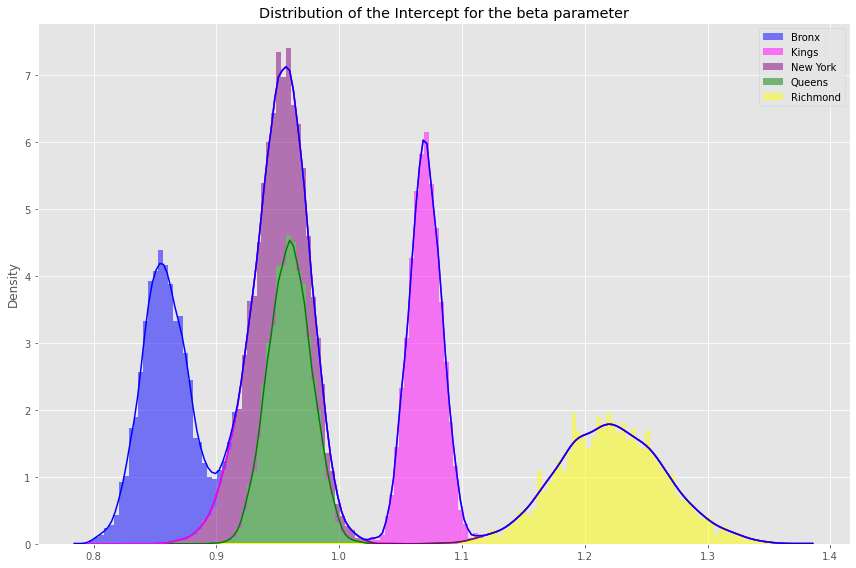

In [ ]:
# Visualize intercept coefficient distribution for each county
fig = plt.figure()
palette = {
    "Bronx" : 'blue',
    "Kings" : 'magenta',
    "New York" : 'purple',
    "Queens" : 'green',
    "Richmond" : 'yellow'
}

# create dataframe and set columns for the relevant counties
df = pd.DataFrame(beta_samples[:,:,0])
df.columns = [cat_string[c] for c in range(len(df.columns))]
sns.histplot(df, multiple="stack", stat="density", bins=150, kde=True, edgecolor="none", palette=palette)
plt.title(f"Distribution of the Intercept for the beta parameter")
fig.tight_layout()
#fig.savefig('output/dist_beta0_hier.pdf', format="pdf")
plt.show()

### Predictions with the hierarchical model
Using the expected values of beta and q from the posterior samples

In [ ]:
beta_hat = np.mean(beta_samples, axis=0)

     #psi_mu = torch.sum(X *beta[cat], axis = 1) 
        
    
        #y = pyro.sample("y", dist.Poisson(torch.exp(alpha + psi_mu)), obs=obs)

psi = np.sum(beta_hat[cat_test] * X_test_std_fs[:, :].numpy(), axis=1)


alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()

y_hat_hpois = np.mean(np.exp(alpha_samples.T + np.dot(X_test_std_fs, beta_samples[:,0].T)), axis=1)

corr, mae, rae, rmse, mse, r2 = compute_error(y_test, y_hat_hpois)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, mse,r2))



CorrCoef: 0.568
MAE: 4.435
RMSE: 6.298
MSE: 39.663
R2: 0.285


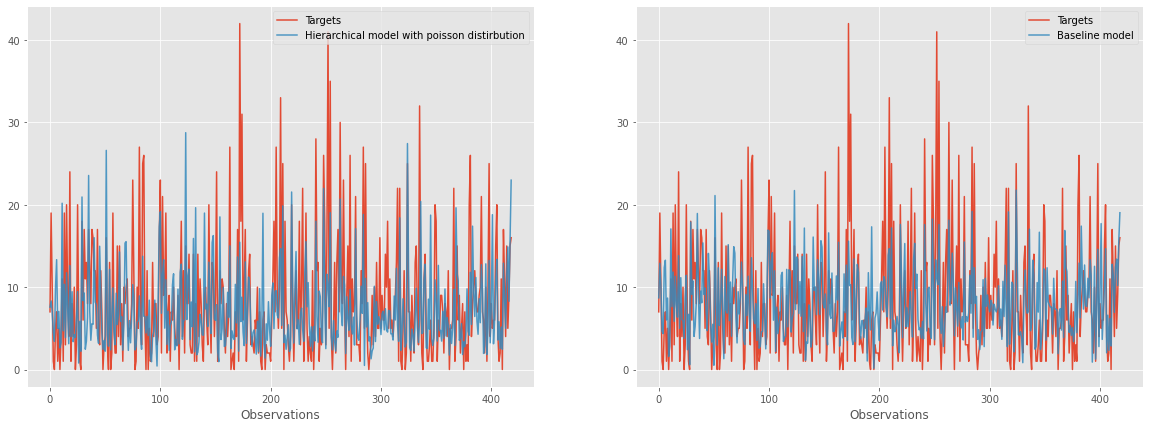

In [ ]:
plot_predictions_comp(y_test,y_hat_hpois,"Hierarchical model with poisson distirbution",y_pred_lreg_fs,"Baseline model")

# Extra model?